# Code for processing ACCESS-S2 forecasts

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [3]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '01:00:00'
cores = 4
memory = str(4 * cores)
memory = memory + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40897 instead
  warnings.warn(


In [4]:
cluster.scale(jobs=1)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.55.59:40897/status,
Dashboard: http://10.6.55.59:40897/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.55.59:37291,Workers: 0
Dashboard: http://10.6.55.59:40897/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
import os
import xarray as xr
# import numpy as np
# import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [7]:
def get_plot_params():
    """
    Get the plotting parameters used for figures
    """
    FONT_SIZE = 7
    COASTLINES_LW = 0.5
    LINEWIDTH = 1.3
    PATHEFFECT_LW_ADD = LINEWIDTH * 1.8

    return {'lines.linewidth': LINEWIDTH,
            'hatch.linewidth': 0.5,
            'font.size': FONT_SIZE,
            'legend.fontsize' : FONT_SIZE - 1,
            'legend.columnspacing': 0.7,
            'legend.labelspacing' : 0.03,
            'legend.handlelength' : 1.,
            'axes.linewidth': 0.5}

plt_params = get_plot_params()

# Load forecast data

In [16]:
fc_path = '/g/data/w42/lz3062/s2_fcst/'

Get initialisation dates

In [72]:
init_dates = sorted(os.listdir(fc_path))

Obtain dataset of all forecasts, with dimensions for ensemble member (member; 1-33), lat, lon, forecast target date (target_date), forecast initialisation date (init_date).

In [73]:
ds_list = []
for init in init_dates:
    members = sorted(os.listdir(fc_path + init))
    files = []
    for member, file in enumerate(members):
        fcast = xr.open_mfdataset(fc_path + init + '/' + file)
        fcast = fcast.expand_dims({'member': [member + 1]})
        files.append(fcast)
        
    fcast_ens = xr.concat(files, dim='member')
    fcast_ens = fcast_ens.rename({'time': 'target_date'})
    fcast_ens = fcast_ens.expand_dims({'init_date': [fcast_ens['target_date'].values[0]]})
    
    ds_list.append(fcast_ens)
    
fcast_ds = xr.concat(ds_list, dim='init_date')

In [74]:
fcast_ds

<xarray.Dataset>
Dimensions:      (member: 33, lat: 324, lon: 432, target_date: 176,
                  init_date: 18)
Coordinates:
  * member       (member) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat          (lat) float32 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon          (lon) float32 0.4167 1.25 2.083 2.917 ... 357.9 358.8 359.6
  * target_date  (target_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-11...
  * init_date    (init_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-10-0...
Data variables:
    pr           (init_date, member, target_date, lat, lon) float32 dask.array<chunksize=(1, 1, 176, 324, 432), meta=np.ndarray>
Attributes: (12/25)
    model_id:                ACCESS-S2
    distribution_statement:  The data are subject to the distribution terms o...
    creator_name:            Bureau of Meteorology
    copyright:               (C) Copyright Commonwealth of Australia (2017), ...
    acknowledgement:         Australian Bureau of Meteorology, Commonwealth o...
    title:                   ACCESS-S2
    ...                      ...
    input_file_format:       UM ancillary
    input_uri:               file:///g/sc/home_prod/coupled_prod/cylc-run/acc...
    input_word_length:       8
    history:                 Wed Feb 23 07:57:16 2022: ncks -O -v pr /g/sc/ho...
    input_byte_ordering:     big_endian
    NCO:                     "4.5.3"

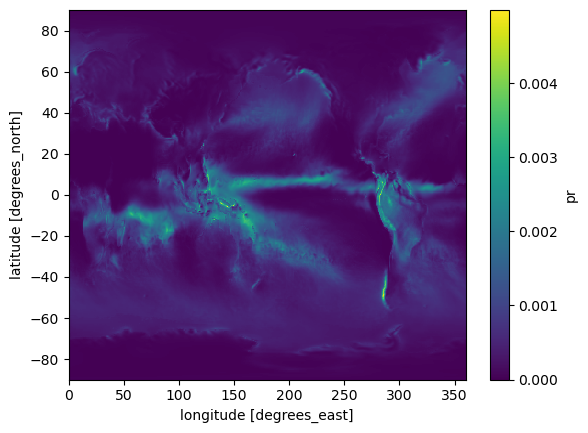

In [71]:
da.pr.sel(target_date=slice('2022-02-25', '2022-03-10')).sum(['target_date']).mean(['member', 'init_date']).plot()